In [5]:
import sqlite3
import pandas as pd

conn = sqlite3.connect('Chinook.db')
cursor = conn.execute("select * from Artist LIMIT 10")
rows = cursor.fetchall()

rows

[(1, 'AC/DC'),
 (2, 'Accept'),
 (3, 'Aerosmith'),
 (4, 'Alanis Morissette'),
 (5, 'Alice In Chains'),
 (6, 'Antônio Carlos Jobim'),
 (7, 'Apocalyptica'),
 (8, 'Audioslave'),
 (9, 'BackBeat'),
 (10, 'Billy Cobham')]

In [6]:
data = ''
with open('Chinook_db_description.txt','r') as file:
    data= file.readlines()

text = " ".join(data)
print(text)


The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 InvoiceDate (DATETIME)
 BillingAddress (

In [32]:
import openai
from openai import OpenAI
from dotenv import load_dotenv, dotenv_values 
from PIL import Image
from io import BytesIO
import time
import pandas as pd
import datetime

load_dotenv()
client = OpenAI()


In [33]:
user_query = "Create a bar plot of the total spend per user. Use vertical labels for the x axis"

In [34]:
schema_template = "Here is the schema of a database. "+text\
    +"\n Write a SQL query to answer the following question. Provide only the SQL and nothing else\n"
user_request = schema_template+user_query
print(user_request)

Here is the schema of a database. The Chinook database is a sample database used for learning and practicing SQL. It mimics a digital media store, including tables for artists, albums, media tracks, invoices, customers, and employees. Here's an overview of the schema:
 
 Tables and their columns:
 Artist
 
 ArtistId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Album
 
 AlbumId (INTEGER, Primary Key)
 Title (NVARCHAR)
 ArtistId (INTEGER, Foreign Key referencing Artist)
 Track
 
 TrackId (INTEGER, Primary Key)
 Name (NVARCHAR)
 AlbumId (INTEGER, Foreign Key referencing Album)
 MediaTypeId (INTEGER, Foreign Key referencing MediaType)
 GenreId (INTEGER, Foreign Key referencing Genre)
 Composer (NVARCHAR)
 Milliseconds (INTEGER)
 Bytes (INTEGER)
 UnitPrice (NUMERIC)
 MediaType
 
 MediaTypeId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Genre
 
 GenreId (INTEGER, Primary Key)
 Name (NVARCHAR)
 Invoice
 
 InvoiceId (INTEGER, Primary Key)
 CustomerId (INTEGER, Foreign Key referencing Customer)
 Invoic

In [35]:
def llm_request(user_prompt):
    completion = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": "You helpful data analyst.Use only the information provided in the text."},
        {"role": "user", "content": user_prompt}
    ]
    )

    result = completion.choices[0].message.content
    return result


In [36]:
result = llm_request(user_request)
my_SQL = result[7:-3]
print(my_SQL)

df = pd.read_sql(my_SQL,conn)
df.head()

SELECT c.FirstName || ' ' || c.LastName AS CustomerName, SUM(i.Total) AS TotalSpend
FROM Customer c
JOIN Invoice i ON c.CustomerId = i.CustomerId
GROUP BY CustomerName
ORDER BY TotalSpend DESC;



,CustomerName,TotalSpend
0,Helena Holý,49.62
1,Richard Cunningham,47.62
2,Luis Rojas,46.62
3,Ladislav Kovács,45.62
4,Hugh O'Reilly,45.62


In [37]:
request = "Here is a sample dataframe "+ df.head().to_string() \
    + " Provide only Python code to answer the following question and nothing else. "\
    + "Assume that the data is available in a dataframe df, and use only data from the sample provided. "\
    + "Don't include any data in the code. "\
    + "Any plots should have a size of 10,5 and a dpi of 300. "
request += user_query
print(request)

Here is a sample dataframe          CustomerName  TotalSpend
0         Helena Holý       49.62
1  Richard Cunningham       47.62
2          Luis Rojas       46.62
3     Ladislav Kovács       45.62
4       Hugh O'Reilly       45.62 Provide only Python code to answer the following question and nothing else. Assume that the data is available in a dataframe df, and use only data from the sample provided. Don't include any data in the code. Any plots should have a size of 10,5 and a dpi of 300. Create a bar plot of the total spend per user. Use vertical labels for the x axis


In [38]:
result = llm_request(request)
code = result[10:-3]
print(code)

```python
import matplotlib.pyplot as plt

df.plot(kind='bar', x='CustomerName', y='TotalSpend')
plt.xlabel('CustomerName', rotation='vertical')
plt.ylabel('Total Spend')
plt.gcf().set_size_inches(10, 5)
plt.gcf().set_dpi(300)
plt.show()
```
import matplotlib.pyplot as plt

df.plot(kind='bar', x='CustomerName', y='TotalSpend')
plt.xlabel('CustomerName', rotation='vertical')
plt.ylabel('Total Spend')
plt.gcf().set_size_inches(10, 5)
plt.gcf().set_dpi(300)
plt.show()



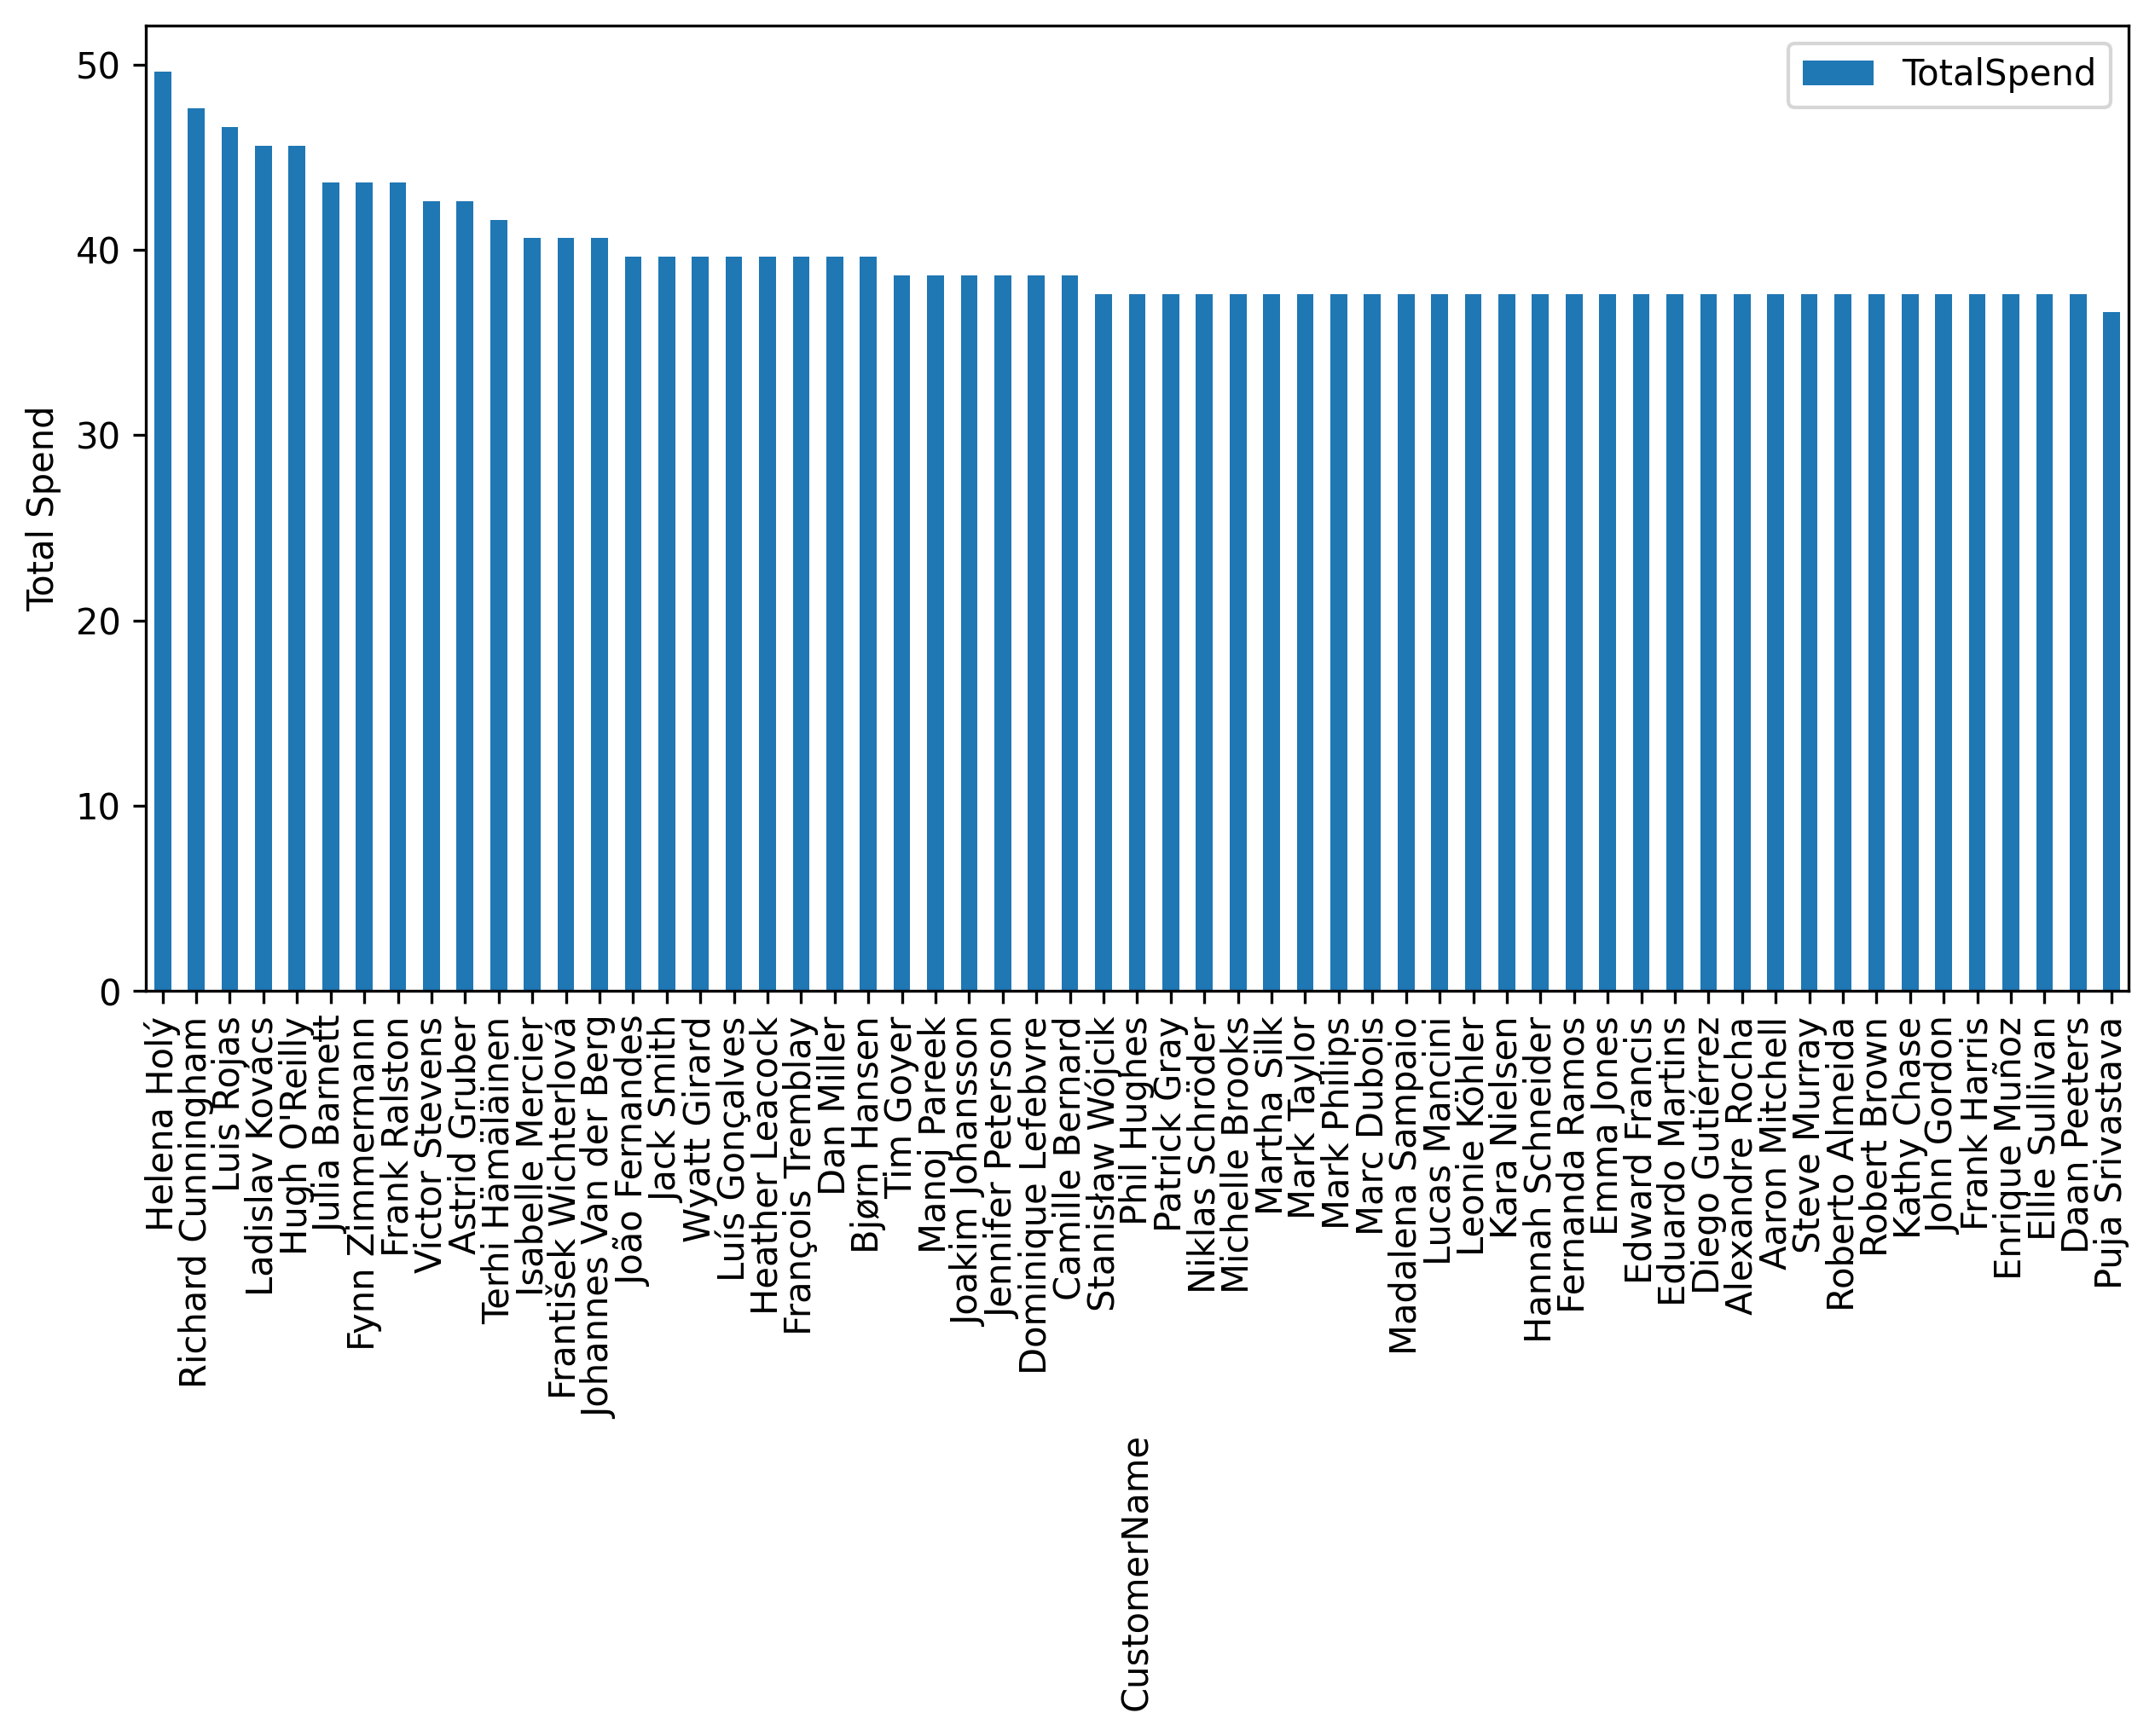

In [39]:
max_tries = 5
tries = 0
while tries < max_tries:
    try:
        exec(code)
        break
    except Exception as e:
        tries +=1
        print(Exception)

In [ ]:
import matplotlib.pyplot as plt

df.plot.bar(x='CustomerId', y='TotalSpend', color='skyblue')
plt.xlabel('Customer ID')
plt.ylabel('Total Spend')
plt.title('Total Spend per User')
plt.show()

In [ ]:
schema_template = "Here is the schema of a database. "+text\
    +"\n Write a SQL query and necessary python code to answer the following question. \
        Provide only the code and nothing else in the form of a dictionary, where the keys are SQL and Python.\
            Assume data for the plot is present in a dataframe called df. Make sure the columns in the SQL output and Python match\n"
user_query = "Create a bar plot of the total spend per user"
user_request = schema_template+user_query
print(user_request)

In [ ]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You helpful data analyst.Use only the information provided in the text."},
    {"role": "user", "content": user_request}
  ]
)

#result_sql = completion.choices[0].message.content
print(completion)

In [ ]:
result = eval(completion.choices[0].message.content)
print(result)
# my_dict = {"A":1,"B":2}
# temp = str(my_dict)
# new_dict= eval(temp)
# new_dict

In [ ]:
df = pd.read_sql(result['SQL'],conn)
df.head()

In [ ]:
result['Python']

In [ ]:
df.plot(kind='bar', x='FirstName LastName', y='TotalSpend', title='Total Spend per User')

In [ ]:
exec(result['Python'])